In [1]:
from setup import *
from utils import *

In [2]:
scene_dir = './chamber_model/components/'
object_format = '.ply'

# Optimization params
spp = 64
iterations = 4
exp = 1

# Set up the scene
materials = create_materials(with_fluids=False)
components = load_components(materials=materials)
components.pop('outer_jar_outer_surface')
components.pop('viewports_outer')
components.pop('viewports_inner')
components.update({'outer_jar_outer_surface_top' :
    mi.load_dict({
        'type': 'ply',
        'filename': scene_dir+'outer_jar_outer_surface_top_distorted'+object_format,
        'face_normals': False,
        'bsdf': materials['outer_jar_outer_surface_mat'],
    })})
components.update({'outer_jar_outer_surface_bottom' :
    mi.load_dict({
        'type': 'ply',
        'filename': scene_dir+'outer_jar_outer_surface_bottom'+object_format,
        'face_normals': False,
        'bsdf': materials['outer_jar_outer_surface_mat'],
    })})
film = {
    'type': 'hdrfilm',
    'rfilter': {
        'type': 'gaussian'
    },
    'width': 640,
    'height': 400,
    'sample_border': True
}
sampler = {
    'type': 'multijitter',
    'sample_count': spp # render with max spp of our optimization process
}
sensor = create_sensor(sensor_number=2, film=film, sampler=sampler, fov=50)
# integrator = {'type': 'prb_projective', 'sppi': 0}
integrator = {'type': 'ptracer', 'samples_per_pass': 256, 'max_depth': 8, 'hide_emitters': False}
scene = load_scene(components=components, sensor=sensor, integrator=integrator)

# Create reference image -- select only red channel
image_ref = render(scene=scene, denoise=False)[:,:,0]**exp
mi.Bitmap(image_ref)

2024-05-29 14:26:05 WARN main [PLYMesh] "outer_jar_outer_surface_top_distorted.ply": skipping unknown element "edge"

Bitmap[
  pixel_format = y,
  component_format = float32,
  size = [640, 400],
  srgb_gamma = 0,
  struct = Struct<4>[
    float32 Y; // @0, premultiplied alpha
  ],
  data = [ 1e+03 KiB of image data ]
]

In [3]:
# Replace top portion of outer jar with undistorted version
components.update({'outer_jar_outer_surface_top' :
    mi.load_dict({
        'type': 'ply',
        'filename': scene_dir+'outer_jar_outer_surface_top'+object_format,
        'face_normals': False,
        'bsdf': materials['outer_jar_outer_surface_mat'],
    })})

scene = load_scene(components=components, sensor=sensor, integrator=integrator)
mi.Bitmap(render(scene=scene, denoise=False)[:,:,0]**exp)

2024-05-29 14:26:10 WARN main [PLYMesh] "outer_jar_outer_surface_top.ply": skipping unknown element "edge"

Bitmap[
  pixel_format = y,
  component_format = float32,
  size = [640, 400],
  srgb_gamma = 0,
  struct = Struct<4>[
    float32 Y; // @0, premultiplied alpha
  ],
  data = [ 1e+03 KiB of image data ]
]

In [4]:
scene_params = mi.traverse(scene)
scene_params

SceneParameters[
  ----------------------------------------------------------------------------------------------------------------
  Name                                                         Flags    Type           Parent
  ----------------------------------------------------------------------------------------------------------------
  cables.bsdf.eta.value                                        ∂, D     Color3f        SRGBReflectanceSpectrum
  cables.bsdf.k.value                                          ∂, D     Color3f        SRGBReflectanceSpectrum
  cables.bsdf.specular_reflectance.value                       ∂        Float          UniformSpectrum
  cables.silhouette_sampling_weight                                     float          PLYMesh
  cables.faces                                                          UInt           PLYMesh
  cables.vertex_positions                                      ∂, D     Float          PLYMesh
  cables.vertex_normals                          

In [5]:
heightmap_resolution = (128,128)

heightmap_texture = mi.load_dict({
    'type': 'bitmap',
    'id': 'heightmap_texture',
    'bitmap': mi.Bitmap(dr.zeros(mi.TensorXf, heightmap_resolution)),
    'raw': True,
})

params = mi.traverse(heightmap_texture)
params.keep(['data']) # Reduce the params to only keep 'data'
# opt = mi.ad.Adam(lr=1e-5, params=params)
opt = mi.ad.SGD(lr=1e-5, params=params)
print(opt)
print(params)

SGD[
  variables = ['data'],
  lr = {'default': 1e-05},
  momentum = 0
]
SceneParameters[
  -----------------------------------------------------------
  Name    Flags    Type     Parent
  -----------------------------------------------------------
  data    ∂        TensorXf BitmapTexture
]


In [6]:
initial_positions = dr.unravel(mi.Vector3f, scene_params['outer_jar_outer_surface_top.vertex_positions'])
initial_normals   = dr.unravel(mi.Vector3f, scene_params['outer_jar_outer_surface_top.vertex_normals'])

print(np.array(initial_positions).shape)
print(np.array(dr.unravel(mi.Vector2f, scene_params['outer_jar_outer_surface_top.vertex_texcoords'])).shape)

outer_jar_outer_surface_top_si = dr.zeros(mi.SurfaceInteraction3f, dr.width(initial_positions))
outer_jar_outer_surface_top_si.uv = dr.unravel(type(outer_jar_outer_surface_top_si.uv), scene_params['outer_jar_outer_surface_top.vertex_texcoords'])

def apply_displacement(amplitude=1.0):
    
    vmax = 1/100
    params['data'] = dr.clamp(params['data'], -vmax, vmax)
    dr.enable_grad(params['data'])

    height_values = heightmap_texture.eval_1(outer_jar_outer_surface_top_si)
    new_positions = (height_values * initial_normals * amplitude + initial_positions)
    scene_params['outer_jar_outer_surface_top.vertex_positions'] = dr.ravel(new_positions)
    scene_params.update()

(883, 3)
(883, 2)


In [7]:
loss_hist = []
for it in range(iterations):
    # Apply discplacement and updated the scene
    apply_displacement()

    # Perform a differentiable render
    # image = mi.render(scene, scene_params, seed=it)[:,:,0]
    image = mi.render(scene, scene_params)[:,:,0]

    # Evaluate the objective function
    # loss = mse(image, image_ref)
    loss = scale_independent_mse(image, image_ref)
    
    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Carry over the update to our 'latent variable' (the heightmap values)
    params.update(opt)

    current_loss = loss[0]
    loss_hist.append(current_loss)
    print(f"Iteration {it:03d}: loss={current_loss:g}", end='\r')

: 

Text(0.5, 1.0, 'Optimized image')

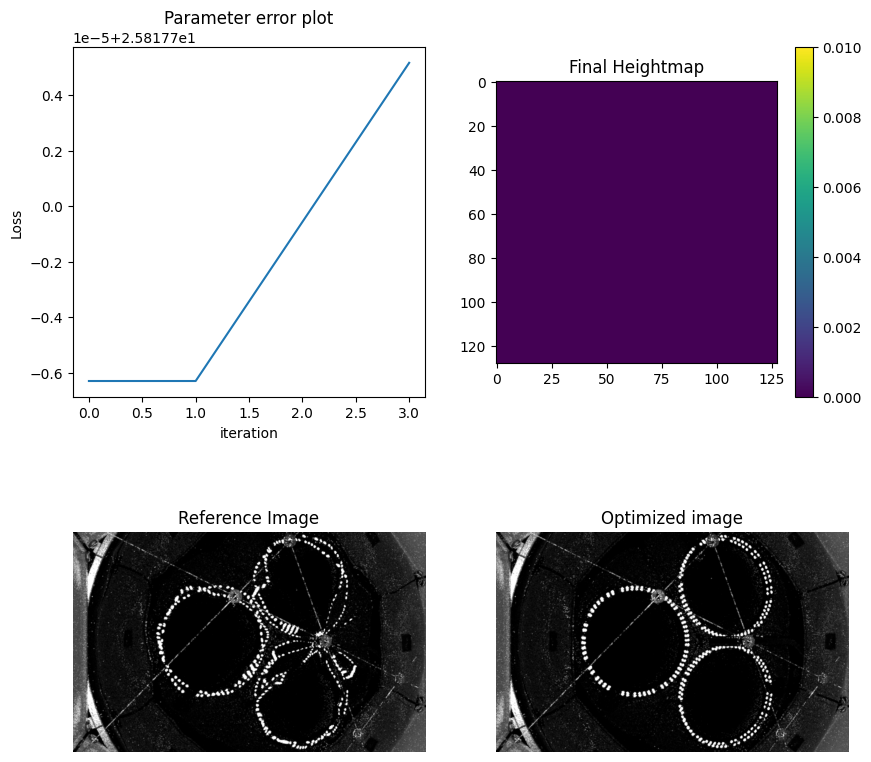

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration'); 
axs[0][0].set_ylabel('Loss'); 
axs[0][0].set_title('Parameter error plot')

# im = axs[0][1].imshow(params['data'].numpy().squeeze(), vmax=1e-4)
im = axs[0][1].imshow(params['data'].numpy().squeeze(), vmax=1/100)
fig.colorbar(im, ax=axs[0][1])
# axs[0][1].axis('off')
axs[0][1].set_title('Final Heightmap')

axs[1][0].imshow(mi.util.convert_to_bitmap(image_ref))
axs[1][0].axis('off')
axs[1][0].set_title('Reference Image')

axs[1][1].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=spp)[:,:,0]))
axs[1][1].axis('off')
axs[1][1].set_title('Optimized image')

In [ ]:
print(loss_hist)

[25.81769371032715, 25.81769371032715, 25.817699432373047, 25.817705154418945]
